In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [2]:
train = pd.read_csv('/kaggle/input/g-research-crypto-forecasting/train.csv')

In [3]:
train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


##### VWAP is average price of asset over the given time interval

In [4]:
bitcoin = train[train['Asset_ID'] == 1].set_index("timestamp")
bitcoin_last_200 = bitcoin.iloc[-200:]
bitcoin_last_200.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1632170460,1,5694.0,43558.393750,43588.680000,43427.28,43447.003750,191.442881,43493.981877,-0.000805
1632170520,1,2528.0,43449.818571,43495.954028,43414.33,43440.000000,80.692018,43455.988146,0.000418
1632170580,1,3985.0,43427.082310,43455.218478,43327.29,43360.723750,117.332513,43391.956795,0.000125
1632170640,1,2185.0,43362.572857,43454.990000,43348.06,43427.242857,76.361478,43403.880056,0.000956
1632170700,1,2623.0,43419.832500,43467.000000,43351.15,43375.040000,76.018320,43408.267118,-0.000430


In [5]:
import plotly.graph_objects as go

fig = go.Figure(data = [go.Candlestick(x=bitcoin_last_200.index, open = bitcoin_last_200['Open'], high = bitcoin_last_200['High'], 
                                      low = bitcoin_last_200['Low'], close = bitcoin_last_200['Close'])])
fig.show()

If red, close was lower than open otherwise green.
Top bits are the high and low prices of that interval.


In [6]:
bitcoin.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956282 non-null  int64  
 1   Count     1956282 non-null  float64
 2   Open      1956282 non-null  float64
 3   High      1956282 non-null  float64
 4   Low       1956282 non-null  float64
 5   Close     1956282 non-null  float64
 6   Volume    1956282 non-null  float64
 7   VWAP      1956282 non-null  float64
 8   Target    1955978 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 149.3 MB


Missing values for Target

In [7]:
bitcoin.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

In [8]:
start_time = bitcoin.index[0].astype('datetime64[s]')
end_time = bitcoin.index[-1].astype('datetime64[s]')
print(start_time)
print(end_time)

2018-01-01T00:01:00
2021-09-21T00:00:00


In [9]:
(bitcoin.index[1:]-bitcoin.index[:-1]).value_counts()

60      1956136
120          78
180          12
240          11
420           9
360           4
600           4
480           3
720           3
840           3
300           3
540           2
1620          2
1800          2
1080          2
2220          1
660           1
1560          1
1020          1
1200          1
2400          1
1440          1
Name: timestamp, dtype: int64

Checking here the unique differences between consecutive rows (to see if there's missing data)

In [10]:
bitcoin = bitcoin.reindex(range(bitcoin.index[0], bitcoin.index[-1]+60, 60), method = 'pad') #reindex takes in start, end and step value, and this method
#is forward filling using prev value

In [11]:
(bitcoin.index[1:]-bitcoin.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

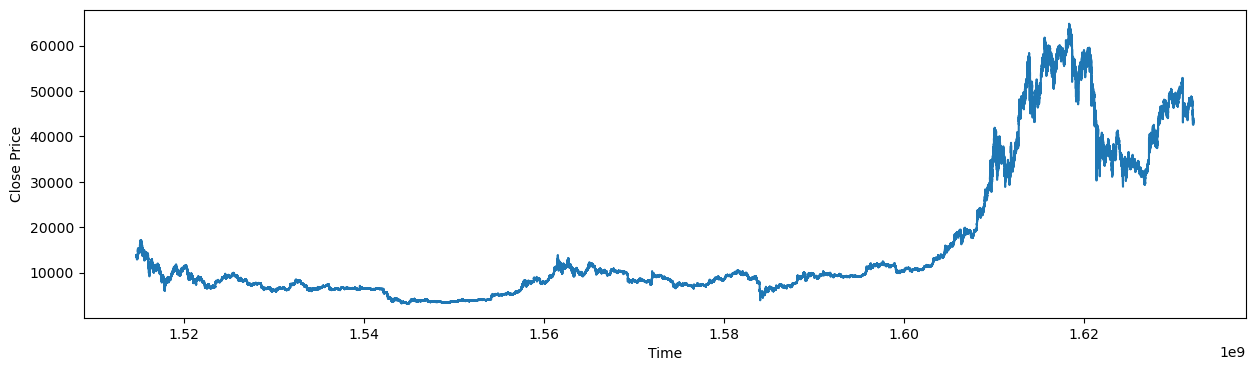

In [12]:
import matplotlib.pyplot as plt


f = plt.figure(figsize=(15,4))
plt.plot(bitcoin['Close'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()

In [13]:
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

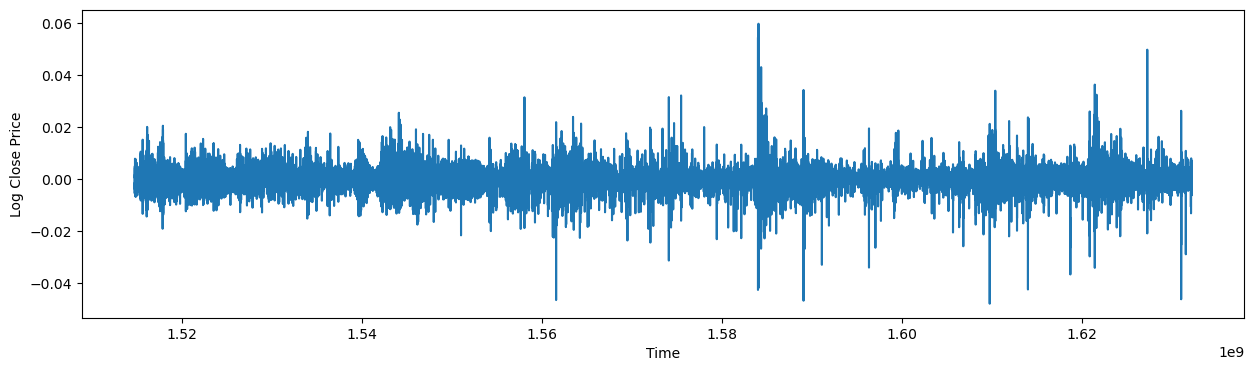

In [14]:
log_ret = log_return(bitcoin['Close'])[1:]
f = plt.figure(figsize=(15,4))
plt.plot(log_ret)
plt.xlabel('Time')
plt.ylabel('Log Close Price')
plt.show()